# IE 8990 Time Series and Forecating Course 
## Project II

Analyzing household power consumption data to forecast the individual household electric power consumption using deep learning techniques.

In [1]:
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

## Read and preprocess the data 
Source: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [5]:
df = pd.read_csv('household_power_consumption.txt', sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [7]:
df.shape

(2075259, 9)

In [8]:
# Check for missing values
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [9]:
# Plot Sub_metering_3 to see if there is a noticeable gap in missing values. 
# Useful to see if there are a lot of consecutive 
# missing values.

na_groups = df['Sub_metering_3'].notna().cumsum()[df['Sub_metering_3'].isna()]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)
len_consecutive_na

Sub_metering_3
6839          2
19722         2
41828         1
61904         1
98248         2
           ... 
1845496       1
1868395       1
1916303    7226
1964211    5237
2001433       1
Name: Sub_metering_3, Length: 71, dtype: int64

In [10]:
longest_na_gap = len_consecutive_na.max()
longest_na_gap

7226

In [11]:
# Remove Sub_metering_3 column as the length of consecutive missing values
# is too large to fill with another value

df = df.drop(['Sub_metering_3'], axis=1)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000


In [12]:
df.dtypes

Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
dtype: object

In [13]:
# Transform all values to numeric except for date and time

cols_to_convert = df.columns[2:]

df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [14]:
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
dtype: object

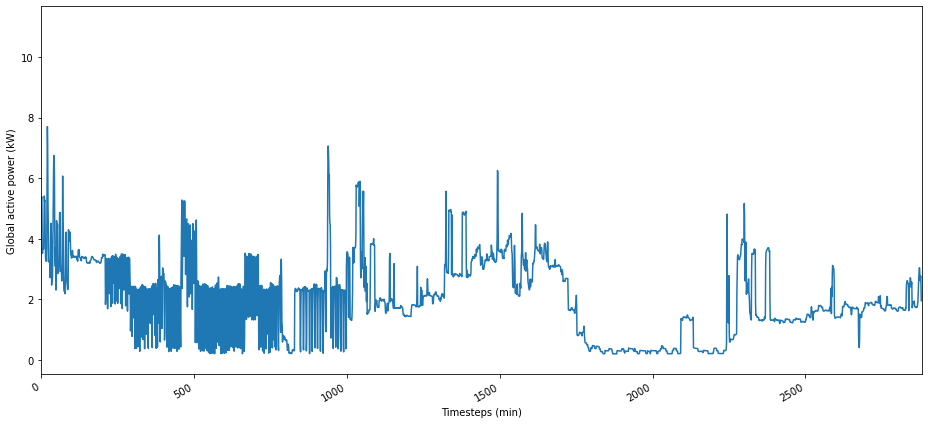

In [15]:
# Plot first 24h (2880 min) of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['Global_active_power'])
ax.set_xlabel('Timesteps (min)')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 2880)

fig.autofmt_xdate()
plt.tight_layout()

In [16]:
# Create new datetime column to have date formatted correctly
df.loc[:,'datetime'] = pd.to_datetime(df.Date.astype(str) + ' ' + df.Time.astype(str))

# Drop old date and tiem columns
df = df.drop(['Date', 'Time'], axis=1)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,2006-12-16 17:28:00


In [17]:
# Sample hourly sum to see if we get a more visible pattern
hourly_df = df.resample('H', on='datetime').sum()
#losing resolution by changing from minutes to hour:under-sampling
hourly_df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0


In [18]:
# Drop first and last row of data so that we have only full 24h sums

hourly_df = hourly_df.drop(hourly_df.tail(1).index)
hourly_df = hourly_df.drop(hourly_df.head(1).index)

hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


In [19]:
hourly_df.shape

(34949, 6)

In [20]:
hourly_df = hourly_df.reset_index()

hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


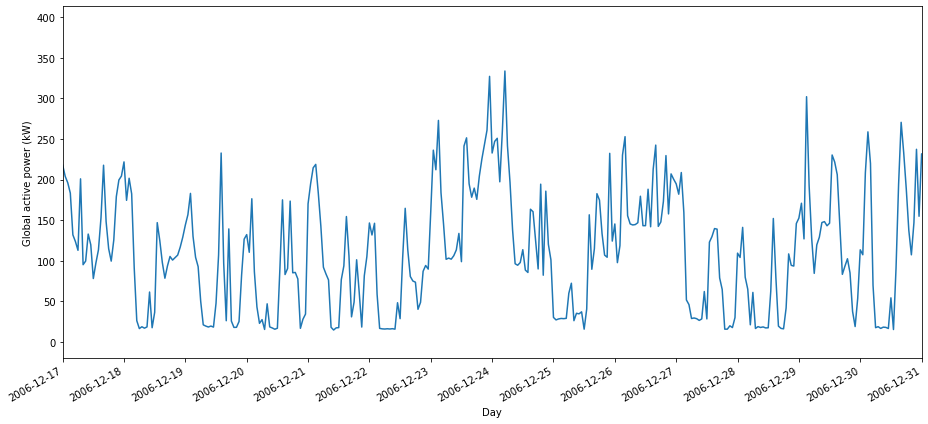

In [21]:
# Plot first 15 full days of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(hourly_df['Global_active_power'])
ax.set_xlabel('Day')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 336)

plt.xticks(np.arange(0, 360, 24), ['2006-12-17', '2006-12-18', '2006-12-19', '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23', '2006-12-24', '2006-12-25', '2006-12-26', '2006-12-27', '2006-12-28', '2006-12-29', '2006-12-30', '2006-12-31'])

fig.autofmt_xdate()
plt.tight_layout()

In [22]:
hourly_df.to_csv('clean_household_power_consumption.csv', header=True, index=False)

## Feature engineering 

In [23]:
hourly_df = pd.read_csv('clean_household_power_consumption.csv')
hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


In [24]:
hourly_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34949.0,64.002817,54.112103,0.0,19.974,45.868,93.738,393.632
Global_reactive_power,34949.0,7.253838,4.113238,0.0,4.558,6.324,8.884,46.460
Voltage,34949.0,14121.298311,2155.548246,0.0,14340.300,14454.060,14559.180,15114.120
Global_intensity,34949.0,271.331557,226.626113,0.0,88.400,196.600,391.600,1703.000
Sub_metering_1,34949.0,65.785430,210.107036,0.0,0.000,0.000,0.000,2902.000
Sub_metering_2,34949.0,76.139861,248.978569,0.0,0.000,19.000,39.000,2786.000


In [25]:
hourly_df = hourly_df.drop(['Sub_metering_1'], axis=1)
hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,8.0


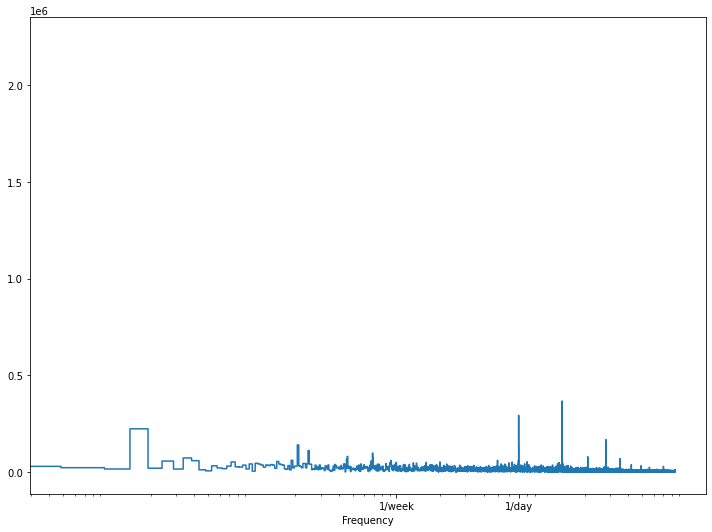

In [26]:
fft = tf.signal.rfft(hourly_df['Global_active_power'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(hourly_df['Global_active_power'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [27]:
timestamp_s = pd.to_datetime(hourly_df.datetime).map(datetime.datetime.timestamp)

day = 24 * 60 * 60
#sin and cos for day cycle of 24 hours
hourly_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
hourly_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [28]:
hourly_df = hourly_df.drop(['datetime'], axis=1)

hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,day_sin,day_cos
0,217.932,4.802,14074.81,936.0,403.0,-7.065073e-12,1.000000
1,204.014,5.114,13993.95,870.2,86.0,2.588190e-01,0.965926
2,196.114,4.506,14044.29,835.0,0.0,5.000000e-01,0.866025
3,183.388,4.600,14229.52,782.8,25.0,7.071068e-01,0.707107
4,132.008,3.370,14325.60,571.4,8.0,8.660254e-01,0.500000


## Split data and scale it

In [29]:
n = len(hourly_df)

# Split 70:20:10 (train:validation:test)
train_df = hourly_df[0:int(n*0.7)]
val_df = hourly_df[int(n*0.7):int(n*0.9)]
test_df = hourly_df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((24464, 7), (6990, 7), (3495, 7))

In [30]:
from sklearn.preprocessing import MinMaxScaler
#scaling them to small size to use them in neural network as a weight
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

## Save to CSV files 

In [31]:
train_df.to_csv('train_project.csv', index=False, header=True)
val_df.to_csv('val_project.csv', index=False, header=True)
test_df.to_csv('test_project.csv', index=False, header=True)
print(train_df.shape, val_df.shape, test_df.shape)

(24464, 7) (6990, 7) (3495, 7)


## `Creating windows of data`

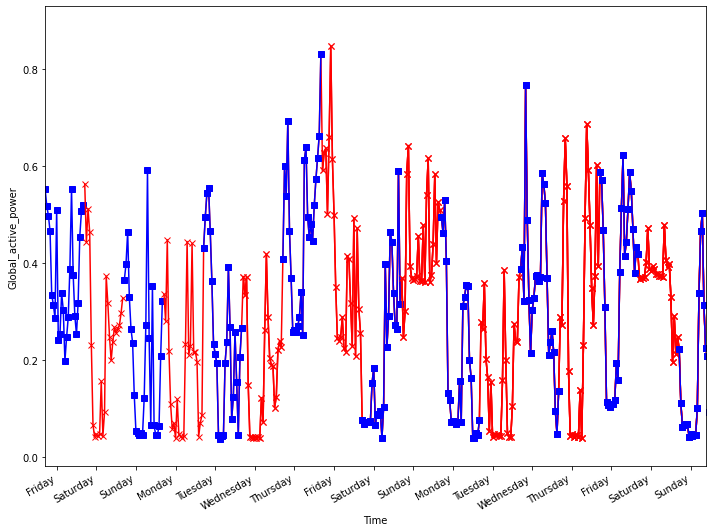

In [32]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.Global_active_power[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.Global_active_power[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Global_active_power')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

In [33]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## Applying baseline models
### Single-step baseline model

In [34]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['Global_active_power']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['Global_active_power'])

In [35]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [36]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['Global_active_power'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [37]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

219/219 [==============================] - 1s 2ms/step - loss: 0.0101 - mean_absolute_error: 0.0651


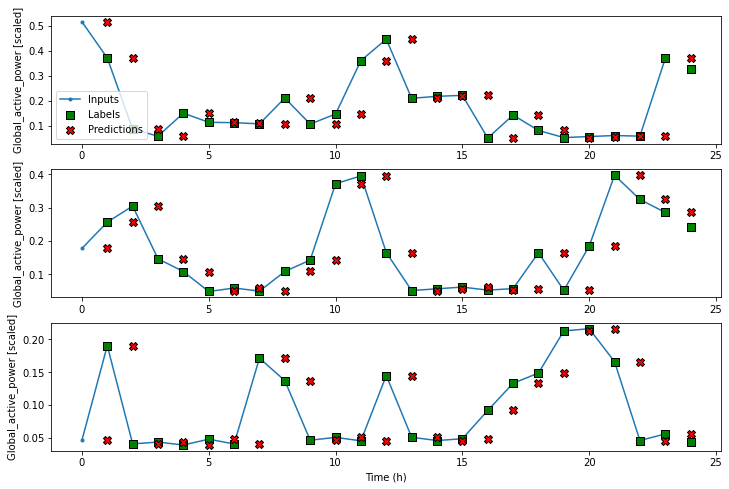

In [38]:
wide_window.plot(baseline_last)

The mean absolute error MAE of the baseline model on the test set is given by:

In [39]:
print(performance['Baseline - Last'][1])

0.05518929287791252


Therefore MAE of single step baseline method is 0.055.

### Multi-step baseline models 

In [40]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Global_active_power'])

#### Predicting the last known value 

In [41]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [42]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['Global_active_power'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 0s 944us/step - loss: 0.1788 - mean_absolute_error: 0.3018


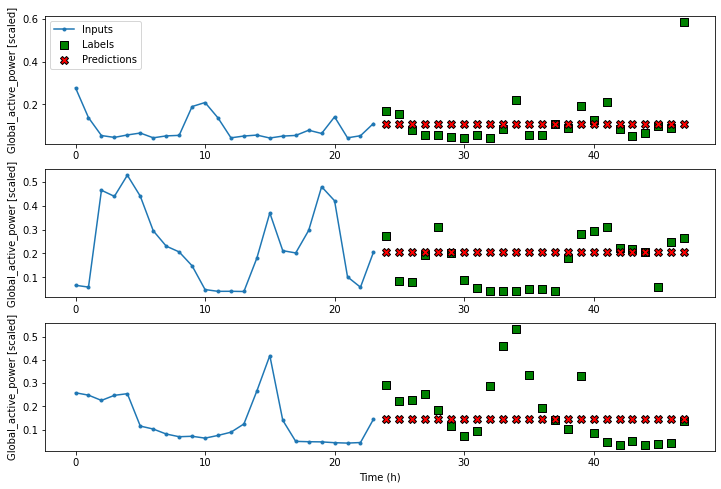

In [43]:
multi_window.plot(ms_baseline_last)

The mean absolute error MAE of the baseline model on the test set is given by:

In [44]:
print(ms_performance['Baseline - Last'][1])

0.28635263442993164


Therefore MAE of the multi step baseline method is 0.286.

#### Repeating the input sequence 

In [45]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [46]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['Global_active_power'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 0s 970us/step - loss: 0.1771 - mean_absolute_error: 0.2950


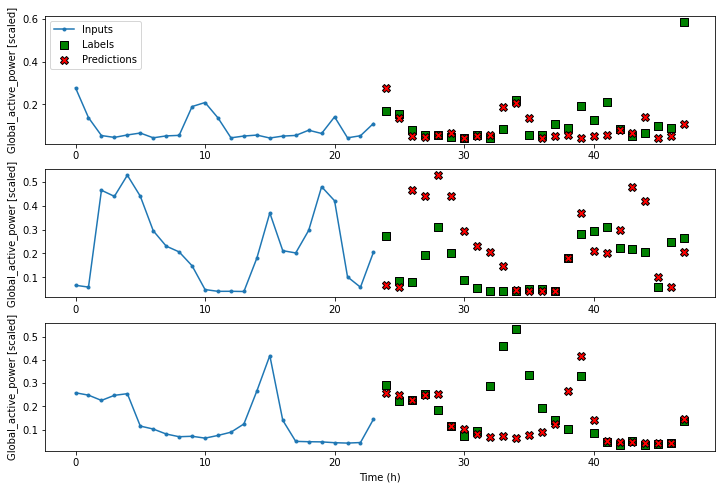

In [47]:
multi_window.plot(ms_baseline_repeat)

The mean absolute error MAE of the baseline model on the test set is given by:

In [48]:
print(ms_performance['Baseline - Repeat'][1])

0.28299808502197266


Therefore MAE of the multi step baseline method with repeating input sequence is 0.282, which is slightly smaller than the multi step baseline model.

### Multi-output baseline model

In [49]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['Global_intensity','Global_active_power']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['Global_intensity','Global_active_power'])

In [50]:
print(column_indices['Global_active_power'])
print(column_indices['Global_intensity'])

0
3


In [51]:
mo_baseline_last = Baseline(label_index=[0, 3])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

218/218 [==============================] - 0s 1ms/step - loss: 0.0099 - mean_absolute_error: 0.0647


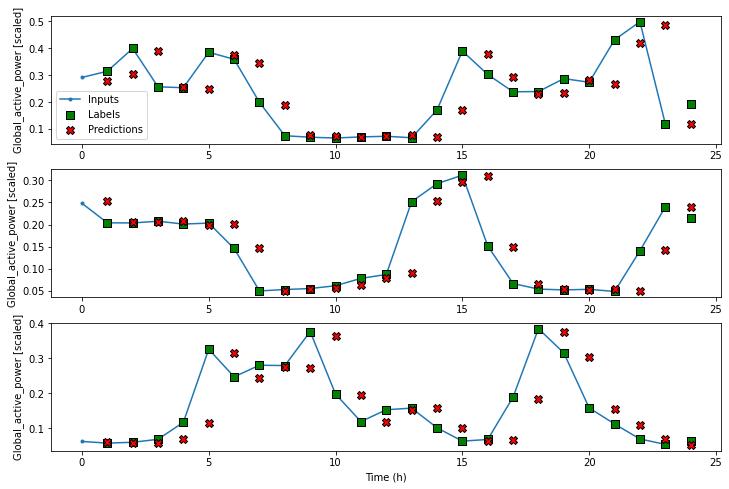

In [52]:
mo_wide_window.plot(mo_baseline_last)

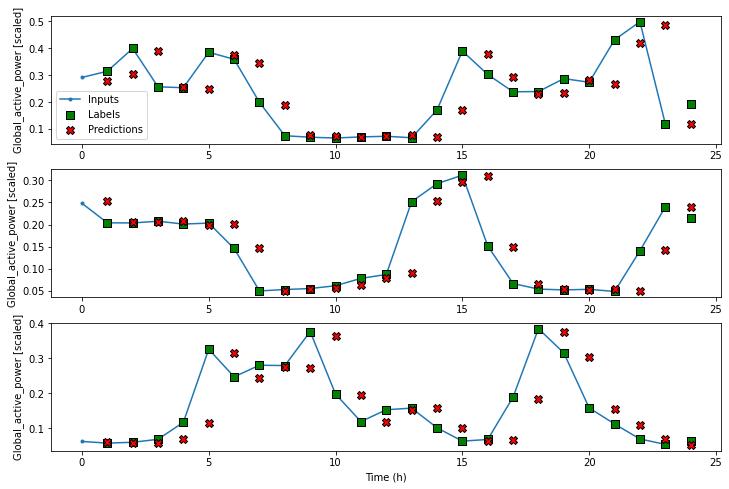

In [53]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='Global_active_power')

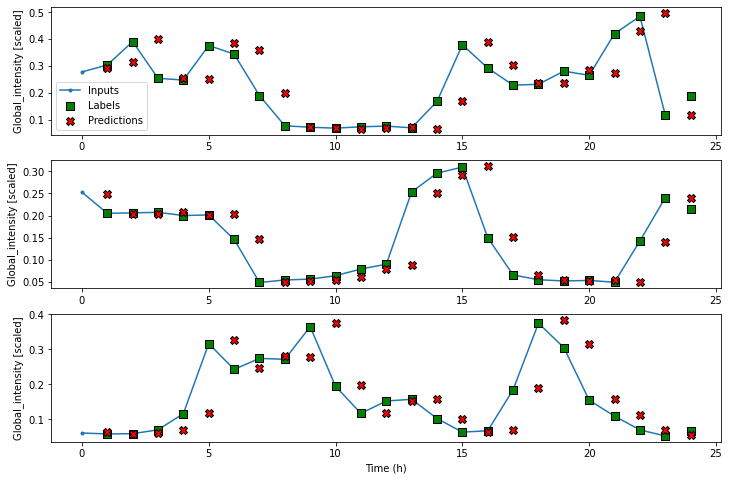

In [54]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='Global_intensity')

In [55]:
print(mo_performance['Baseline - Last'][1])

0.054614998400211334


Therefore the MAE of the baseline model initialized with our two target variables is 0.0546.

## Implementing a linear model
### Building a single-step linear model

In [56]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [57]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0380 - mean_absolute_error: 0.1476 - val_loss: 0.0165 - val_mean_absolute_error: 0.0930
Epoch 2/50
765/765 [==============================] - 1s 1ms/step - loss: 0.0117 - mean_absolute_error: 0.0788 - val_loss: 0.0119 - val_mean_absolute_error: 0.0766
Epoch 3/50
765/765 [==============================] - 1s 1ms/step - loss: 0.0102 - mean_absolute_error: 0.0718 - val_loss: 0.0111 - val_mean_absolute_error: 0.0732
Epoch 4/50
765/765 [==============================] - 1s 1ms/step - loss: 0.0099 - mean_absolute_error: 0.0706 - val_loss: 0.0106 - val_mean_absolute_error: 0.0710
Epoch 5/50
765/765 [==============================] - 1s 1ms/step - loss: 0.0098 - mean_absolute_error: 0.0702 - val_loss: 0.0101 - val_mean_absolute_error: 0.0708
Epoch 6/50
765/765 [==============================] - 1s 1ms/step - loss: 0.0097 - mean_absolute_error: 0.0699 - val_loss: 0.0098 - val_mean_absolute_error: 0.0689
Epoch 7/50
765/7

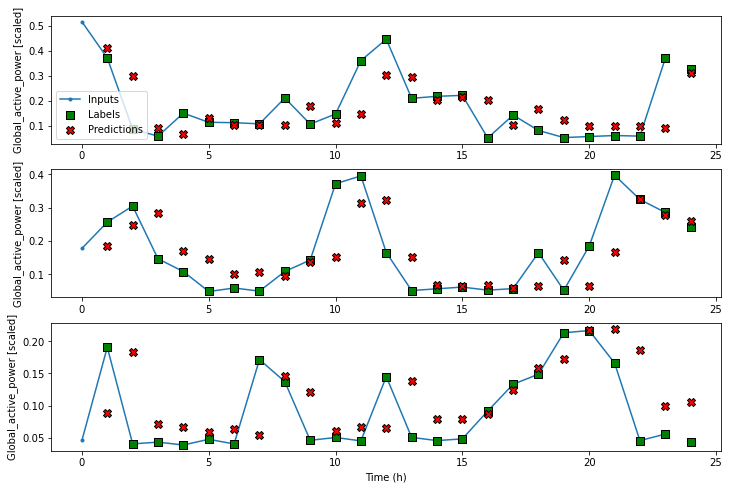

In [58]:
wide_window.plot(linear)

### Building a mutli-step linear model 

In [59]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 1s 2ms/step - loss: 0.0176 - mean_absolute_error: 0.1032 - val_loss: 0.0141 - val_mean_absolute_error: 0.0912
Epoch 2/50
764/764 [==============================] - 1s 1ms/step - loss: 0.0162 - mean_absolute_error: 0.0977 - val_loss: 0.0140 - val_mean_absolute_error: 0.0904
Epoch 3/50
764/764 [==============================] - 1s 1ms/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0140 - val_mean_absolute_error: 0.0904
Epoch 4/50
764/764 [==============================] - 1s 1ms/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0140 - val_mean_absolute_error: 0.0909
Epoch 5/50
764/764 [==============================] - 1s 1ms/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0140 - val_mean_absolute_error: 0.0905
Epoch 6/50
764/764 [==============================] - 1s 1ms/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0140 - val_mean_absolute_error: 0.0911
Epoch 7/50
764/7

### Implementing a multi-output linear model 


In [60]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0699 - mean_absolute_error: 0.1896 - val_loss: 0.0245 - val_mean_absolute_error: 0.1128
Epoch 2/50
765/765 [==============================] - 1s 2ms/step - loss: 0.0210 - mean_absolute_error: 0.1021 - val_loss: 0.0124 - val_mean_absolute_error: 0.0797
Epoch 3/50
765/765 [==============================] - 1s 2ms/step - loss: 0.0121 - mean_absolute_error: 0.0798 - val_loss: 0.0092 - val_mean_absolute_error: 0.0681
Epoch 4/50
765/765 [==============================] - 1s 2ms/step - loss: 0.0098 - mean_absolute_error: 0.0714 - val_loss: 0.0085 - val_mean_absolute_error: 0.0647
Epoch 5/50
765/765 [==============================] - 1s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0688 - val_loss: 0.0085 - val_mean_absolute_error: 0.0635
Epoch 6/50
765/765 [==============================] - 1s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0680 - val_loss: 0.0083 - val_mean_absolute_error: 0.0637
Epoch 7/50
765/7

## Implementing a deep neural network
### Implementing a deep neural network as a single-step model

In [61]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
765/765 [==============================] - 3s 2ms/step - loss: 0.0094 - mean_absolute_error: 0.0678 - val_loss: 0.0072 - val_mean_absolute_error: 0.0584
Epoch 2/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0084 - mean_absolute_error: 0.0640 - val_loss: 0.0080 - val_mean_absolute_error: 0.0603
Epoch 3/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0637 - val_loss: 0.0071 - val_mean_absolute_error: 0.0585
Epoch 4/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0631 - val_loss: 0.0072 - val_mean_absolute_error: 0.0579
Epoch 5/50
765/765 [==============================] - 1s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0626 - val_loss: 0.0071 - val_mean_absolute_error: 0.0570
Epoch 6/50
219/219 [==============================] - 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0592


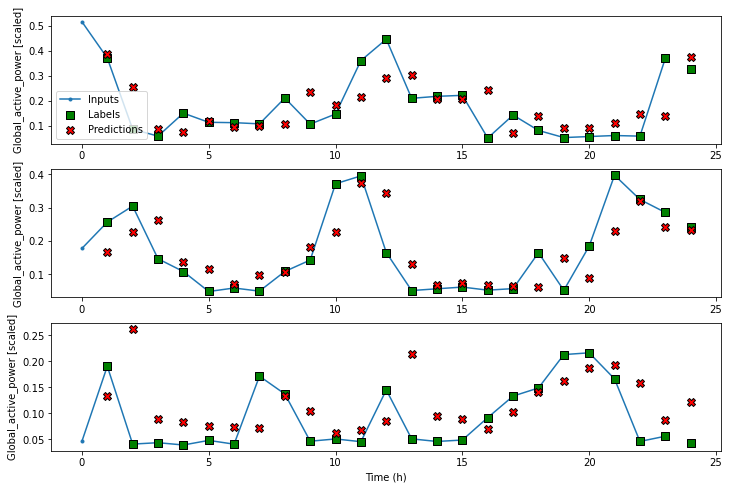

In [62]:
wide_window.plot(dense)

In [63]:
len(performance)

3

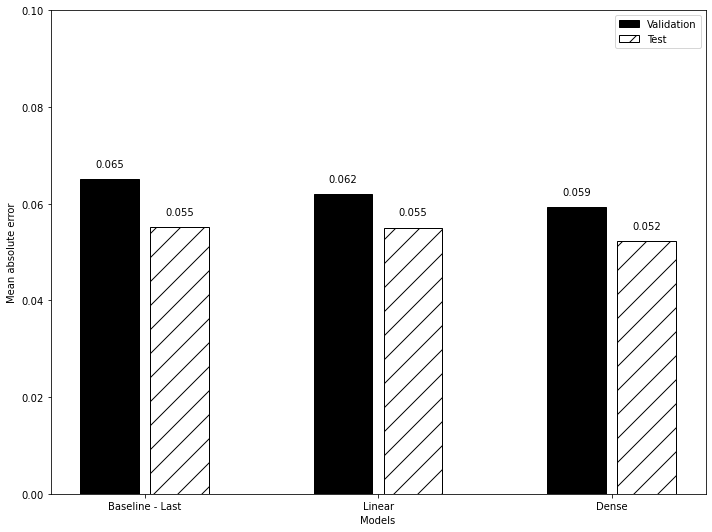

In [64]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

Comparing MAE of the single step baseline method using last known value with single step linear model and dense deep neural network, all the models show similar performance. But, overall, Dense neural network model has the lowest mean absolute error.   

### Implementing a deep neural network as a multi-step model 


In [65]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 3s 3ms/step - loss: 0.0156 - mean_absolute_error: 0.0932 - val_loss: 0.0129 - val_mean_absolute_error: 0.0834
Epoch 2/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0897 - val_loss: 0.0129 - val_mean_absolute_error: 0.0839
Epoch 3/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0896 - val_loss: 0.0129 - val_mean_absolute_error: 0.0839
Epoch 4/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0146 - mean_absolute_error: 0.0893 - val_loss: 0.0128 - val_mean_absolute_error: 0.0834
Epoch 5/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0146 - mean_absolute_error: 0.0891 - val_loss: 0.0128 - val_mean_absolute_error: 0.0846
Epoch 6/50
764/764 [==============================] - 3s 3ms/step - loss: 0.0145 - mean_absolute_error: 0.0888 - val_loss: 0.0128 - val_mean_absolute_error: 0.0845
Epoch 7/50
764/7

In [66]:
ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 0s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0851


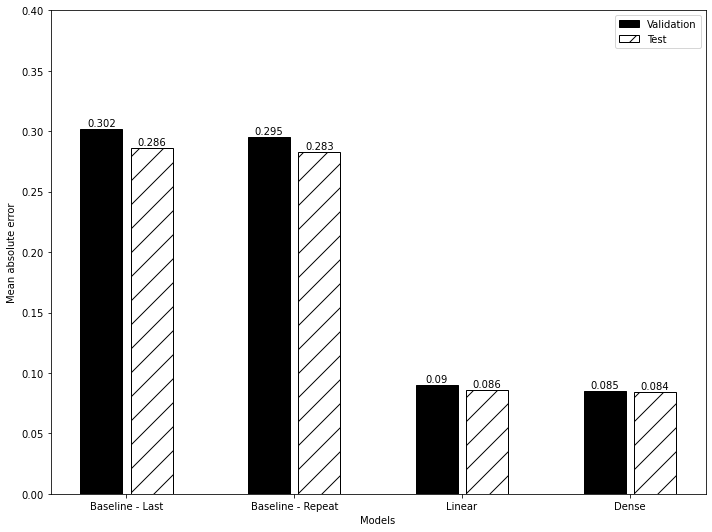

In [67]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

In [68]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]
ms_mae_val

[0.30176401138305664,
 0.2949860990047455,
 0.09021183103322983,
 0.08508653193712234]

Looking at the plot above, the MAE of the multi-step baseline method using last known value with and without repeating the input sequence are significantly higher than the errors of the multi-step linear model and dense deep neural network. Comparing these last two, Dense neural network performs better since it has the lowest mean absolute error.   

### Implementing a deep neural network as a multi-output model 

In [69]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0652 - val_loss: 0.0081 - val_mean_absolute_error: 0.0686
Epoch 2/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0628 - val_loss: 0.0071 - val_mean_absolute_error: 0.0579
Epoch 3/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0623 - val_loss: 0.0071 - val_mean_absolute_error: 0.0584
Epoch 4/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0620 - val_loss: 0.0073 - val_mean_absolute_error: 0.0633
Epoch 5/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0615 - val_loss: 0.0072 - val_mean_absolute_error: 0.0604
Epoch 6/50
765/765 [==============================] - 2s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0616 - val_loss: 0.0070 - val_mean_absolute_error: 0.0584
Epoch 7/50
765/7

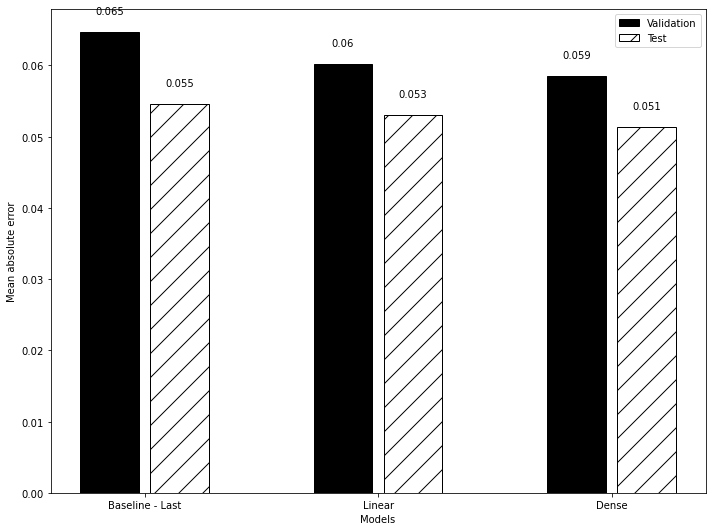

In [71]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

#plt.ylim(0, 0.45)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

Similarly, the MAE of the multi-output baseline method using last known are significantly higher than the errors of the multi-step linear model and dense deep neural network. And, Dense neural network performs better overall, since it has the lowest mean absolute error.   

## Implementing CNN 

In [72]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [73]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

### Implementing CNN as a multi-step model 

In [74]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['Global_active_power'])

In [75]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, wide_conv_window)

#val_performance = {}
#performance = {}

ms_val_performance['CNN'] = cnn_model.evaluate(wide_conv_window.val)
ms_performance['CNN'] = cnn_model.evaluate(wide_conv_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 3s 3ms/step - loss: 0.0148 - mean_absolute_error: 0.0904 - val_loss: 0.0131 - val_mean_absolute_error: 0.0831
Epoch 2/50
763/763 [==============================] - 2s 3ms/step - loss: 0.0144 - mean_absolute_error: 0.0888 - val_loss: 0.0129 - val_mean_absolute_error: 0.0859
Epoch 3/50
763/763 [==============================] - 2s 3ms/step - loss: 0.0144 - mean_absolute_error: 0.0887 - val_loss: 0.0129 - val_mean_absolute_error: 0.0836
Epoch 4/50
763/763 [==============================] - 2s 3ms/step - loss: 0.0143 - mean_absolute_error: 0.0883 - val_loss: 0.0129 - val_mean_absolute_error: 0.0845
Epoch 5/50
217/217 [==============================] - 0s 2ms/step - loss: 0.0131 - mean_absolute_error: 0.0850


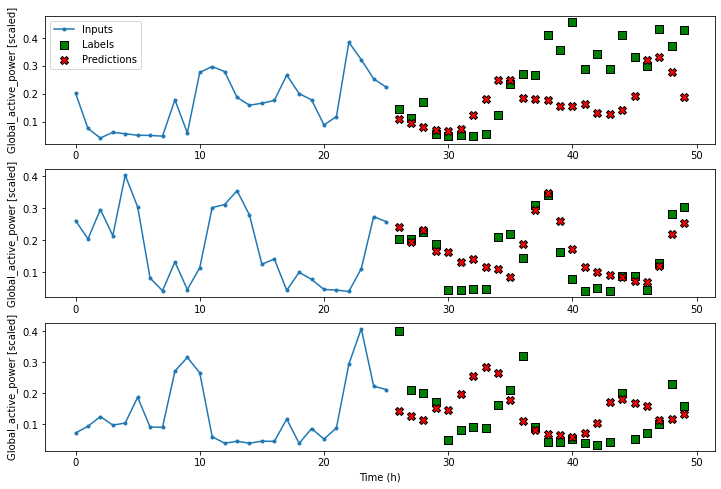

In [76]:
wide_conv_window.plot(cnn_model)

### Implementing CNN as a multi-output model 

In [77]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['Global_intensity','Global_active_power'])

In [78]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 3s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0662 - val_loss: 0.0069 - val_mean_absolute_error: 0.0572
Epoch 2/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0076 - mean_absolute_error: 0.0600 - val_loss: 0.0068 - val_mean_absolute_error: 0.0569
Epoch 3/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0075 - mean_absolute_error: 0.0593 - val_loss: 0.0068 - val_mean_absolute_error: 0.0569
Epoch 4/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0074 - mean_absolute_error: 0.0590 - val_loss: 0.0067 - val_mean_absolute_error: 0.0571
Epoch 5/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0074 - mean_absolute_error: 0.0588 - val_loss: 0.0067 - val_mean_absolute_error: 0.0559
Epoch 6/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0584 - val_loss: 0.0067 - val_mean_absolute_error: 0.0572
Epoch 7/50
764/7

## Implementing LSTM 


### Implementing LSTM as a multi-step model 

In [79]:

wide_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Global_active_power'])

In [80]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)


ms_val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
ms_performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 20s 21ms/step - loss: 0.0171 - mean_absolute_error: 0.0989 - val_loss: 0.0135 - val_mean_absolute_error: 0.0871
Epoch 2/50
764/764 [==============================] - 14s 18ms/step - loss: 0.0150 - mean_absolute_error: 0.0915 - val_loss: 0.0127 - val_mean_absolute_error: 0.0852
Epoch 3/50
764/764 [==============================] - 13s 17ms/step - loss: 0.0147 - mean_absolute_error: 0.0900 - val_loss: 0.0127 - val_mean_absolute_error: 0.0831
Epoch 4/50
764/764 [==============================] - 12s 16ms/step - loss: 0.0145 - mean_absolute_error: 0.0893 - val_loss: 0.0127 - val_mean_absolute_error: 0.0835
Epoch 5/50
764/764 [==============================] - 13s 17ms/step - loss: 0.0145 - mean_absolute_error: 0.0890 - val_loss: 0.0126 - val_mean_absolute_error: 0.0831
Epoch 6/50
764/764 [==============================] - 13s 17ms/step - loss: 0.0144 - mean_absolute_error: 0.0888 - val_loss: 0.0128 - val_mean_absolute_error: 0.0822
Epoc

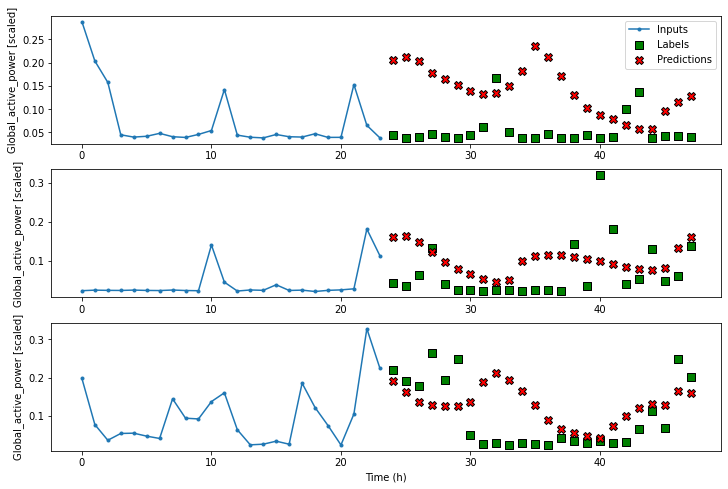

In [81]:
wide_window.plot(lstm_model)

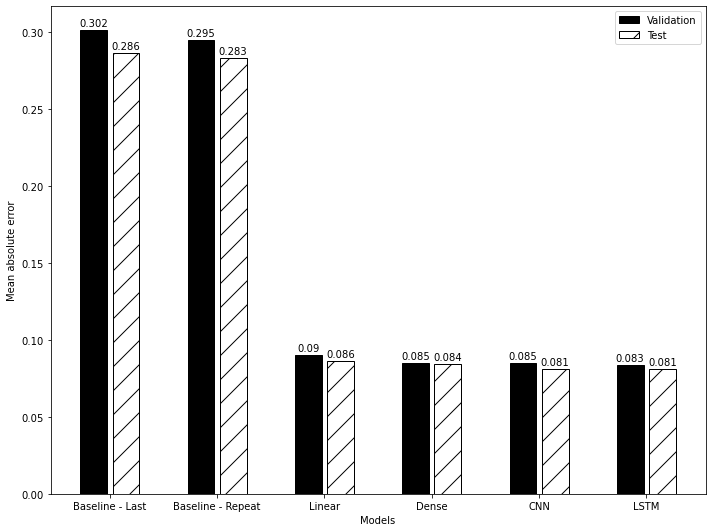

In [83]:
val=[v[1] for v in ms_val_performance.values()]
tes=[v[1] for v in ms_performance.values()]

x = np.arange(len(ms_val_performance))

labels = ['Baseline - Last','Baseline - Repeat', 'Linear', 'Dense', 'CNN','LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, tes, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(tes):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    

plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

Looking at the plot above, the MAE of the multi-step last know baseline method with and without input sequence repitition are the highest ones, whereas CNN and LSTM models perform better overall, since they have the lowest mean absolute error then linear and Dense neural network.

### Implementing LSTM as a multi-output model 

In [84]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 11s 11ms/step - loss: 0.0110 - mean_absolute_error: 0.0752 - val_loss: 0.0075 - val_mean_absolute_error: 0.0628
Epoch 2/50
764/764 [==============================] - 8s 10ms/step - loss: 0.0083 - mean_absolute_error: 0.0642 - val_loss: 0.0073 - val_mean_absolute_error: 0.0617
Epoch 3/50
764/764 [==============================] - 7s 9ms/step - loss: 0.0081 - mean_absolute_error: 0.0629 - val_loss: 0.0072 - val_mean_absolute_error: 0.0615
Epoch 4/50
764/764 [==============================] - 7s 9ms/step - loss: 0.0080 - mean_absolute_error: 0.0619 - val_loss: 0.0070 - val_mean_absolute_error: 0.0591
Epoch 5/50
764/764 [==============================] - 7s 9ms/step - loss: 0.0078 - mean_absolute_error: 0.0610 - val_loss: 0.0069 - val_mean_absolute_error: 0.0589
Epoch 6/50
764/764 [==============================] - 7s 9ms/step - loss: 0.0077 - mean_absolute_error: 0.0605 - val_loss: 0.0069 - val_mean_absolute_error: 0.0595
Epoch 7/50
76

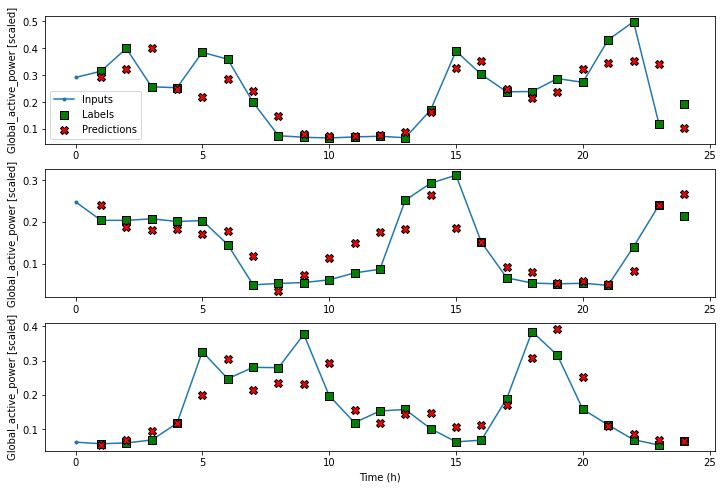

In [85]:
mo_wide_window.plot(mo_lstm_model)

## Implementing CNN +LSTM

### Implementing CNN +LSTM as a multi-step model 

In [86]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['Global_active_power'])

cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, wide_conv_window)

ms_val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(wide_conv_window.val)
ms_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(wide_conv_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 17s 18ms/step - loss: 0.0159 - mean_absolute_error: 0.0946 - val_loss: 0.0134 - val_mean_absolute_error: 0.0844
Epoch 2/50
763/763 [==============================] - 13s 17ms/step - loss: 0.0145 - mean_absolute_error: 0.0891 - val_loss: 0.0131 - val_mean_absolute_error: 0.0835
Epoch 3/50
763/763 [==============================] - 14s 18ms/step - loss: 0.0143 - mean_absolute_error: 0.0882 - val_loss: 0.0132 - val_mean_absolute_error: 0.0838
Epoch 4/50
763/763 [==============================] - 13s 17ms/step - loss: 0.0142 - mean_absolute_error: 0.0879 - val_loss: 0.0128 - val_mean_absolute_error: 0.0842
Epoch 5/50
763/763 [==============================] - 13s 17ms/step - loss: 0.0141 - mean_absolute_error: 0.0874 - val_loss: 0.0129 - val_mean_absolute_error: 0.0842
Epoch 6/50
763/763 [==============================] - 17s 22ms/step - loss: 0.0140 - mean_absolute_error: 0.0872 - val_loss: 0.0131 - val_mean_absolute_error: 0.0835
Epoc

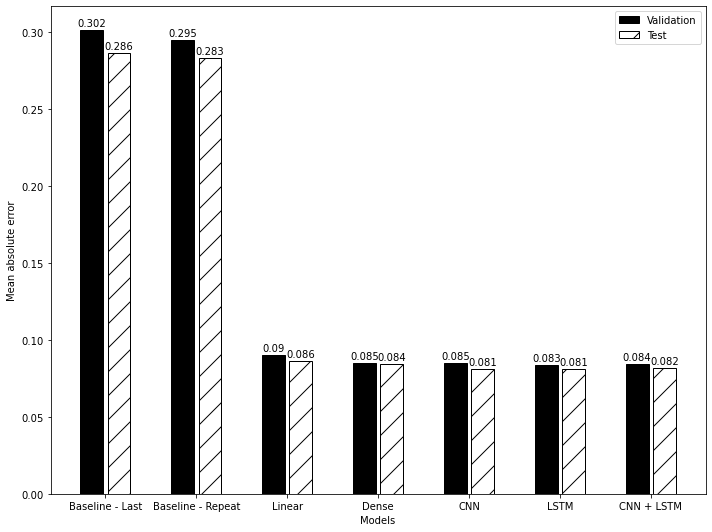

In [88]:
mae_val=[v[1] for v in ms_val_performance.values()]
mae_test=[v[1] for v in ms_performance.values()]

x = np.arange(len(ms_val_performance))

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense',  'CNN','LSTM', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

Combining CNN with LSTM shows similar performance to CNN and LSTM. However, multistep CNN and LSTM models have the lowest MAE compared to the other methods when forecasting for Global_active_power.

### Implementing CNN +LSTM as a multi-output model 

In [89]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 18s 20ms/step - loss: 0.0105 - mean_absolute_error: 0.0728 - val_loss: 0.0071 - val_mean_absolute_error: 0.0588
Epoch 2/50
764/764 [==============================] - 14s 18ms/step - loss: 0.0079 - mean_absolute_error: 0.0616 - val_loss: 0.0069 - val_mean_absolute_error: 0.0594
Epoch 3/50
764/764 [==============================] - 14s 18ms/step - loss: 0.0076 - mean_absolute_error: 0.0603 - val_loss: 0.0068 - val_mean_absolute_error: 0.0594
Epoch 4/50
764/764 [==============================] - 15s 20ms/step - loss: 0.0075 - mean_absolute_error: 0.0597 - val_loss: 0.0068 - val_mean_absolute_error: 0.0577
Epoch 5/50
764/764 [==============================] - 14s 19ms/step - loss: 0.0074 - mean_absolute_error: 0.0592 - val_loss: 0.0067 - val_mean_absolute_error: 0.0570
Epoch 6/50
764/764 [==============================] - 14s 19ms/step - loss: 0.0073 - mean_absolute_error: 0.0587 - val_loss: 0.0067 - val_mean_absolute_error: 0.0577
Epoc

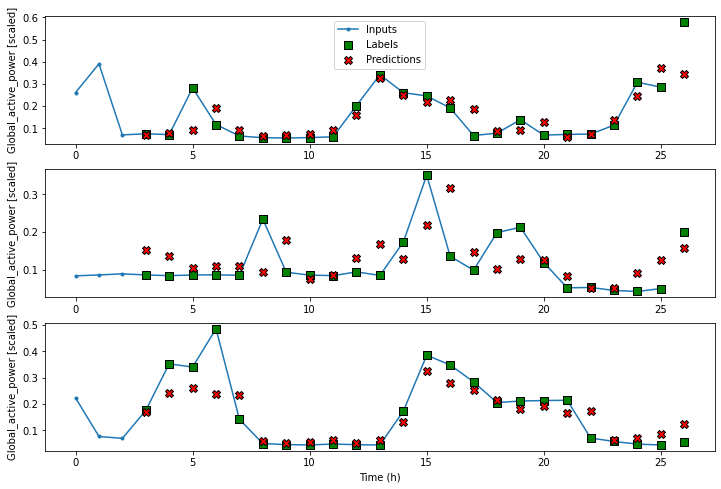

In [90]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

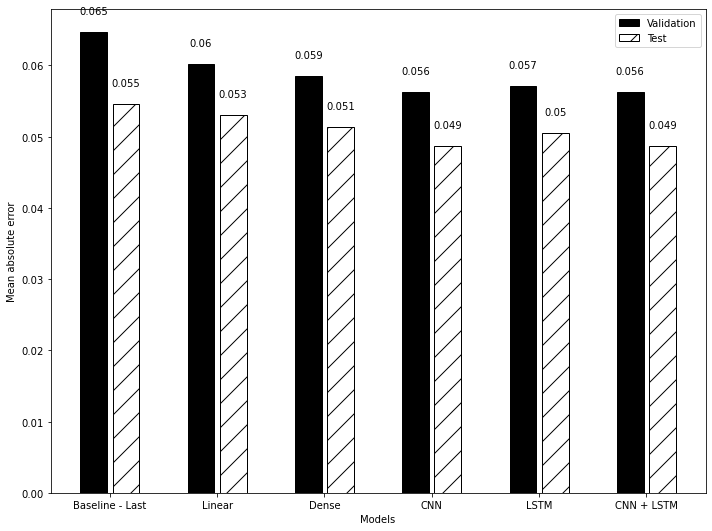

In [92]:
mo_mae_val=[v[1] for v in mo_val_performance.values()]
mo_mae_test=[v[1] for v in mo_performance.values()]

x = np.arange(len(mo_val_performance))

labels = ['Baseline - Last', 'Linear', 'Dense', 'CNN', 'LSTM','CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

In the plot above, different multi output models were used to forcast both Global_intensity and Global_active_power. The baseline model using last know value has the highest mean absolute error followed by linear, dense and LSTM models. However, CNN and CNN+LSTM perform better than the other methods.  

##  Implementing ARLSTM

###  Implementing ARLSTM as a multi-step model

In [93]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Global_active_power'])

In [94]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [95]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 15s 14ms/step - loss: 0.0174 - mean_absolute_error: 0.1018 - val_loss: 0.0132 - val_mean_absolute_error: 0.0848
Epoch 2/50
764/764 [==============================] - 12s 16ms/step - loss: 0.0141 - mean_absolute_error: 0.0880 - val_loss: 0.0125 - val_mean_absolute_error: 0.0841
Epoch 3/50
764/764 [==============================] - 12s 16ms/step - loss: 0.0140 - mean_absolute_error: 0.0872 - val_loss: 0.0126 - val_mean_absolute_error: 0.0828
Epoch 4/50
764/764 [==============================] - 12s 16ms/step - loss: 0.0139 - mean_absolute_error: 0.0866 - val_loss: 0.0124 - val_mean_absolute_error: 0.0836
Epoch 5/50
764/764 [==============================] - 10s 13ms/step - loss: 0.0138 - mean_absolute_error: 0.0862 - val_loss: 0.0123 - val_mean_absolute_error: 0.0816
Epoch 6/50
764/764 [==============================] - 10s 13ms/step - loss: 0.0137 - mean_absolute_error: 0.0858 - val_loss: 0.0124 - val_mean_absolute_error: 0.0823
Epoc

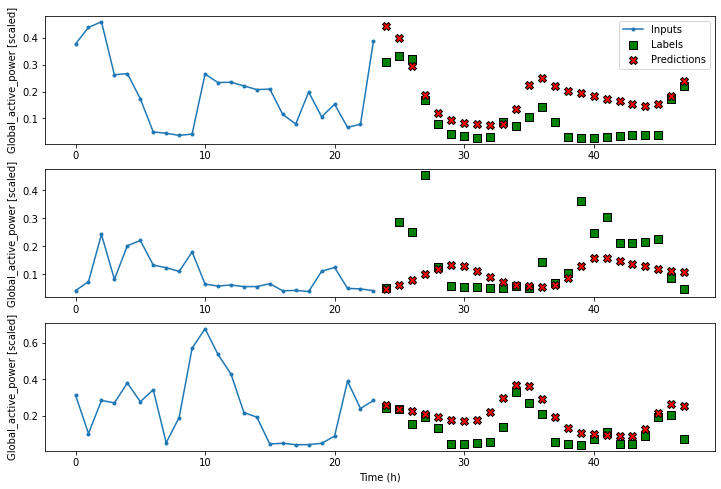

In [96]:
multi_window.plot(AR_LSTM)

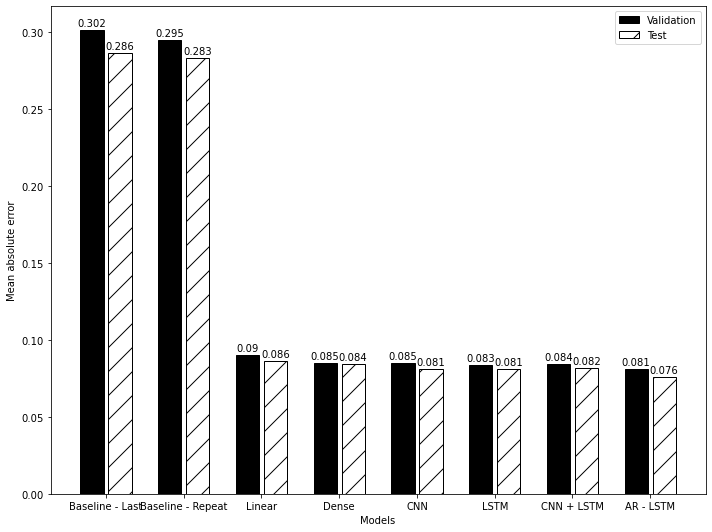

In [98]:
ms_mae_val=[v[1] for v in ms_val_performance.values()]
ms_mae_test=[v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'CNN', 'LSTM', 'CNN + LSTM', 'AR - LSTM']
#labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'AR - LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.18, ms_mae_val, width=0.3, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.18, ms_mae_test, width=0.3, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

Comparing the MAE of the multi-step baseline methods using last known with and without repeating the input sequence with other methods, the errors are significantly higher. And, ARLSTM shows the best performance since it has the lowest mean absolute error when forecasting the individual houshold energy consumption compared to to the other multistep models used: Linear, dense, CNN, LSTM and the combination of CNN and LSTM.   